# Random Forest Hyperparameter Tuning

This notebook is a walkthrough on training hyperparameters on the Random Forest machine learning model. We will be training the model on the real/fake news dataset. Analysis of the dataset can be found in the main notebook.

For the purpose of this exercise and time, we will be looking at only 2000 examples for each class as training/computation time is very expensive.

## Import data

In [1]:
# Import our visual libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import text clearning libraries
import re
from bs4 import BeautifulSoup
import nltk
from pprint import pprint

#Import data
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [2]:
# Import real and fake datasets
# Sample of 2000 random examples for each class
real = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv").sample(2000)
fake = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv").sample(2000)

# Merge the datasets
real["label"] = 1
fake["label"] = 0

frame = [real, fake]
df = pd.concat(frame)

df.head()

,title,text,subject,date,label
13974,German president to hold joint talks with Merk...,BERLIN (Reuters) - German President Frank-Walt...,worldnews,"November 24, 2017",1
2693,Senate intel panel wants to interview everyone...,WASHINGTON (Reuters) - The leaders of the U.S....,politicsNews,"July 18, 2017",1
7789,Trump to propose five-year lobbying ban on ex-...,"GREEN BAY, Wis. (Reuters) - Republican preside...",politicsNews,"October 17, 2016",1
3612,Trump proposes deep U.S. spending cuts in Mexi...,MEXICO CITY (Reuters) - President Donald Trump...,politicsNews,"May 23, 2017",1
4220,"U.S., Japan agree China should play larger rol...",TOKYO (Reuters) - U.S. Vice President Mike Pen...,politicsNews,"April 18, 2017",1


In [3]:
df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [4]:
# Run this cell to avoid indexes of previous datasets from overlapping
df.reset_index(inplace = True)
df.drop("index", axis=1, inplace = True)

## Text Processing

In [5]:
# Want to remove entries which are not dates
# See main notebook for more details
df = df[df["date"].apply(lambda x: len(x) < 20)]
df.head()

,title,text,subject,date,label
0,German president to hold joint talks with Merk...,BERLIN (Reuters) - German President Frank-Walt...,worldnews,"November 24, 2017",1
1,Senate intel panel wants to interview everyone...,WASHINGTON (Reuters) - The leaders of the U.S....,politicsNews,"July 18, 2017",1
2,Trump to propose five-year lobbying ban on ex-...,"GREEN BAY, Wis. (Reuters) - Republican preside...",politicsNews,"October 17, 2016",1
3,Trump proposes deep U.S. spending cuts in Mexi...,MEXICO CITY (Reuters) - President Donald Trump...,politicsNews,"May 23, 2017",1
4,"U.S., Japan agree China should play larger rol...",TOKYO (Reuters) - U.S. Vice President Mike Pen...,politicsNews,"April 18, 2017",1


In [6]:
# Merge text and title columns, remove title, subject and date.
df['text'] = df['title'] + " " + df['text']
del df['title']
del df['subject']
del df['date']

In [7]:
# Check if anything missing after cleaning
df.isna().sum()

text     0
label    0
dtype: int64

In [8]:
# Stopwords to remove from text will have little effect on the context of the text
# Stopwords in list already in lower case
from nltk.corpus import stopwords

In [9]:
# Functions for cleaning text

# Use this to deal with apostophes and abbreviation
def remove_apostrophe_abbrev(text):
    return re.sub('[^\w\s]','', text)

# Function to remove stopwords
def remove_stop_words(text):
    clean_text = []
    stop_words = stopwords.words('english')
    for word in text.split():
        if word.strip().lower() not in stop_words:
            clean_text.append(word)
            
    return " ".join(clean_text)

# Remove html tags, using regex is bad idea
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Remove links in text, http and https
# s? in regex means or s (case sensitive)
def remove_links(text):
    return re.sub('https?:\/\/\S+', '', text)

# Remove 's (possessive pronouns) from text
# Two kinds of apostophes found
def remove_possessive_pronoun(text):
    return re.sub("’s|'s", '', text)

# Remove between brackets and their contents
def remove_between_brackets(text):
    return re.sub('\([^]]*\)', '', text)

# Remove square brackets and their contents
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Remove curly brackets and their contents
# Useful to remove any JavaScript scripts, though removed
# through html as above
def remove_between_curly_brackets(text):
    return re.sub('\{[^]]*\}', '', text)

def remove_n_space(text):
    return re.sub('\n', '', text)



In [10]:
# Function to clean text in text column
def text_cleaner(text):
    text = remove_html_tags(text)
    text = remove_links(text)
    text = remove_possessive_pronoun(text)
    text = remove_apostrophe_abbrev(text)
    text = remove_between_brackets(text)
    text = remove_between_square_brackets(text)
    text = remove_between_curly_brackets(text)
    text = remove_n_space(text)
    text = remove_stop_words(text)
    
    return text

In [11]:
# Apply cleaning functions to text
df["text"] = df["text"].apply(text_cleaner)

In [12]:
df["text"][0]

'German president hold joint talks Merkel Schulz next week BERLIN Reuters German President FrankWalter Steinmeier host joint meeting next week Chancellor Angela Merkel leader centerleft Social Democrats SPD head Bavarian Christian Social Union CSU spokeswoman said Merkel Christian Democrats CDU CSU Bavarian sister party ruled SPD grand coalition since 2013 caretaker government remains place election September meeting week leaders CDU CSU SPD federal president agreed meet joint meeting Schloss Bellevue Steinmeier spokeswoman said statement meeting takes place next week exact date communicated later time'

### Lemmatization

In [13]:
from nltk.stem import WordNetLemmatizer

lemma = WordNetLemmatizer()

# Function to perform lemmatization on text
def lemmatize_text(text):
    tokenize_text = nltk.word_tokenize(text)
    lemmatize_words = [lemma.lemmatize(word) for word in tokenize_text]
    join_text = ' '.join(lemmatize_words)
    
    return join_text

# Copy main df dataset and lemmatize the text
lemmatized_df = df.copy()
lemmatized_df["text"] = lemmatized_df["text"].apply(lemmatize_text)
lemmatized_df.head()

,text,label
0,German president hold joint talk Merkel Schulz...,1
1,Senate intel panel want interview everyone Tru...,1
2,Trump propose fiveyear lobbying ban exexecutiv...,1
3,Trump proposes deep US spending cut Mexico Cen...,1
4,US Japan agree China play larger role North Ko...,1


## Random Forest

In [14]:
# Imports from Scikit-Learn library
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

In [15]:
# Random state at 42 for reproducibility
# Go for 80:20 train:test set
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(lemmatized_df["text"], 
                                                    lemmatized_df["label"], 
                                                    test_size=test_size, 
                                                    random_state=42)

In [ ]:
# Fit CountVectorizer to X_train and X_test datasets
cv_train = CountVectorizer(max_features=10000).fit(X_train)
X_vec_train = cv_train.transform(X_train)
X_vec_test = cv_train.transform(X_test)

In [ ]:
# Shape of vectorized train and test sets
# max_features = 10000
print(X_vec_train.shape)
print(X_vec_test.shape)

In [16]:
# Import Random Forest model
rf = RandomForestClassifier()

print("current model parameters:")
pprint(rf.get_params())

current model parameters:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [23]:
# Import pipeline
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('count', CountVectorizer(max_features=10000, stop_words='english')),
                    ('rfmodel', rf)])

#pipeline.fit(X_train, y_train)

### Random Search Cross Validation

[TowardsDataScience](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) article here.
[GitHub](https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/04.%20Model%20Training/06.%20MT%20-%20Random%20Forest.ipynb) notebook here.

For the purpose of this exercise, we will be tuning these hyperparameters

*     n_estimators = number of trees in the foreset
*     max_features = max number of features considered for splitting a node
*     max_depth = max number of levels in each decision tree
*     min_samples_split = min number of data points placed in a node before the node is split
*     min_samples_leaf = min number of data points allowed in a leaf node
*     bootstrap = method for sampling data points (with or without replacement)

In [28]:
# Parameters names in pipeline
# Model begins with rfmodel__
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'count', 'rfmodel', 'count__analyzer', 'count__binary', 'count__decode_error', 'count__dtype', 'count__encoding', 'count__input', 'count__lowercase', 'count__max_df', 'count__max_features', 'count__min_df', 'count__ngram_range', 'count__preprocessor', 'count__stop_words', 'count__strip_accents', 'count__token_pattern', 'count__tokenizer', 'count__vocabulary', 'rfmodel__bootstrap', 'rfmodel__ccp_alpha', 'rfmodel__class_weight', 'rfmodel__criterion', 'rfmodel__max_depth', 'rfmodel__max_features', 'rfmodel__max_leaf_nodes', 'rfmodel__max_samples', 'rfmodel__min_impurity_decrease', 'rfmodel__min_impurity_split', 'rfmodel__min_samples_leaf', 'rfmodel__min_samples_split', 'rfmodel__min_weight_fraction_leaf', 'rfmodel__n_estimators', 'rfmodel__n_jobs', 'rfmodel__oob_score', 'rfmodel__random_state', 'rfmodel__verbose', 'rfmodel__warm_start'])

In [29]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]

# max_features
max_features = ['log2', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(start = 10, stop = 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# keys begin with rfmodel__ for ml model
random_grid = {
    "rfmodel__n_estimators": n_estimators,
    "rfmodel__max_features": max_features,
    "rfmodel__max_depth": max_depth,
    "rfmodel__min_samples_split": min_samples_split,
    "rfmodel__min_samples_leaf": min_samples_leaf,
    "rfmodel__bootstrap": bootstrap
}

pprint(random_grid)

{'rfmodel__bootstrap': [True, False],
 'rfmodel__max_depth': [10, 32, 55, 77, 100, None],
 'rfmodel__max_features': ['log2', 'sqrt'],
 'rfmodel__min_samples_leaf': [1, 2, 4],
 'rfmodel__min_samples_split': [2, 5, 10],
 'rfmodel__n_estimators': [200, 650, 1100, 1550, 2000]}


In [30]:
# 1080 different hyperparameter combinations!
print(2*6*2*3*3*5)

1080


**Training RandomGridCV**

Now lets use the RandomGridCV to look for the best hyperparameters for the model. Only a fixed number of parameters are sampled from the random grid distributions.

In [31]:
# This run took ~12 minutes
# more information: 
# https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html


# Set k-fold Cross Validation to 3
# Will be looking for 50 random iterations of hyperparameters
# n_jobs=1 will slow down output time and increase randomized search time
# n_jobs paralelizes training task to cores on cpu
random_search = RandomizedSearchCV(estimator=pipeline, 
                                   param_distributions=random_grid,
                                   n_iter = 50, 
                                   scoring='roc_auc', 
                                   cv = 3, 
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs=-1)

# Fit the random search model
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  9.1min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('count',
                                              CountVectorizer(max_features=10000,
                                                              stop_words='english')),
                                             ('rfmodel',
                                              RandomForestClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'rfmodel__bootstrap': [True, False],
                                        'rfmodel__max_depth': [10, 32, 55, 77,
                                                               100, None],
                                        'rfmodel__max_features': ['log2',
                                                                  'sqrt'],
                                        'rfmodel__min_samples_leaf': [1, 2, 4],
                                        'rfmodel__min_samples_split': [2, 5,
                                          

How to decrease computation time on Random and GridSearch:
* Use less values in your hyperparameter distribution
* Decrease number of iterations
* Train on less Cross Validation sets, default set at cv=5
* Use parallel training on cpu by setting n_jobs=-1 on RandomSearchCV/GridSearchCV
* Training using cloud services such as AWS
* Use faster models such as Gradient Boosting/ Light GBM which utilises GPU.

In [32]:
# Results of RandomSearchCV
print("Best parameters found from RandomSearchCV")
print(random_search.best_params_)
print("Average score of model with these hyperparameters")
print(random_search.best_score_)

Best parameters found from RandomSearchCV
{'rfmodel__n_estimators': 2000, 'rfmodel__min_samples_split': 5, 'rfmodel__min_samples_leaf': 1, 'rfmodel__max_features': 'sqrt', 'rfmodel__max_depth': 100, 'rfmodel__bootstrap': False}
Average score of model with these hyperparameters
0.9986341205492346


### Training with GridSearchCV

Now we've seen the hyperparameters from Random Search, lets narrow down the choices of values and train with Grid Search.

In [33]:
# Time taken to train: ~13 minutes

# n_estimators
n_estimators = [1500, 1700, 2000]

# max_features
max_features = ['sqrt']

# max_depth
max_depth = [90, 100, 110]

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [False]

parameter_grid = {
    "rfmodel__n_estimators": n_estimators,
    "rfmodel__max_features": max_features,
    "rfmodel__max_depth": max_depth,
    "rfmodel__min_samples_split": min_samples_split,
    "rfmodel__min_samples_leaf": min_samples_leaf,
    "rfmodel__bootstrap": bootstrap
}

# Set k-fold Cross Validation to 3
grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=parameter_grid,
                           scoring='roc_auc', 
                           cv = 3, 
                           verbose=2, 
                           n_jobs=-1)

# Fit the grid search to model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 33.9min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('count',
                                        CountVectorizer(max_features=10000,
                                                        stop_words='english')),
                                       ('rfmodel', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rfmodel__bootstrap': [False],
                         'rfmodel__max_depth': [90, 100, 110],
                         'rfmodel__max_features': ['sqrt'],
                         'rfmodel__min_samples_leaf': [1, 2, 4],
                         'rfmodel__min_samples_split': [2, 5, 10],
                         'rfmodel__n_estimators': [1500, 1700, 2000]},
             scoring='roc_auc', verbose=2)

In [34]:
# Results of GridSearchCV
print("Best parameters found from GridSearchCV:")
print(grid_search.best_params_)
print("Average score of model with these hyperparameters:")
print(grid_search.best_score_)

Best parameters found from GridSearchCV:
{'rfmodel__bootstrap': False, 'rfmodel__max_depth': 90, 'rfmodel__max_features': 'sqrt', 'rfmodel__min_samples_leaf': 1, 'rfmodel__min_samples_split': 2, 'rfmodel__n_estimators': 1700}
Average score of model with these hyperparameters:
0.9986352943468986


Best parameters found from GridSearchCV: <br>
{'rfmodel__bootstrap': False, 'rfmodel__max_depth': 90, 'rfmodel__max_features': 'sqrt', 'rfmodel__min_samples_leaf': 1, 'rfmodel__min_samples_split': 2, 'rfmodel__n_estimators': 1700}

Average score of model with these hyperparameters: <br>
0.9986352943468986


Let's save the best model with these hyperparameters.

In [35]:
best_rfc = grid_search.best_estimator_
best_rfc

Pipeline(steps=[('count',
                 CountVectorizer(max_features=10000, stop_words='english')),
                ('rfmodel',
                 RandomForestClassifier(bootstrap=False, max_depth=90,
                                        max_features='sqrt',
                                        n_estimators=1700))])

In [36]:
# All parameters of best_rfc
pprint(best_rfc.get_params())

{'count': CountVectorizer(max_features=10000, stop_words='english'),
 'count__analyzer': 'word',
 'count__binary': False,
 'count__decode_error': 'strict',
 'count__dtype': <class 'numpy.int64'>,
 'count__encoding': 'utf-8',
 'count__input': 'content',
 'count__lowercase': True,
 'count__max_df': 1.0,
 'count__max_features': 10000,
 'count__min_df': 1,
 'count__ngram_range': (1, 1),
 'count__preprocessor': None,
 'count__stop_words': 'english',
 'count__strip_accents': None,
 'count__token_pattern': '(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'memory': None,
 'rfmodel': RandomForestClassifier(bootstrap=False, max_depth=90, max_features='sqrt',
                       n_estimators=1700),
 'rfmodel__bootstrap': False,
 'rfmodel__ccp_alpha': 0.0,
 'rfmodel__class_weight': None,
 'rfmodel__criterion': 'gini',
 'rfmodel__max_depth': 90,
 'rfmodel__max_features': 'sqrt',
 'rfmodel__max_leaf_nodes': None,
 'rfmodel__max_samples': None,
 'rfmodel__min_impurity_d

In [37]:
# A look at the base random forest model with default parameters
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


## Model Training and Evaluation

**Model Training**

In [45]:
# Training on best Random Forest model

# Fit to training set
best_rfc.fit(X_train, y_train)

# Make prediction to test set
predicted_value = best_rfc.predict(X_test)

# Get ROC score
best_rfc_accuracy_value = roc_auc_score(y_test, predicted_value)

**Training Accuracy**

In [39]:
# Best Random Forest Training ROC 100% lemmatized text
print("ROC: " + str(roc_auc_score(y_train, best_rfc.predict(X_train))*100) + "%")

ROC: 100.0%


**Test Accuracy**

In [40]:
# Random Forest Test ROC 98.99% lemmatized text
print("ROC: " + str(best_rfc_accuracy_value*100) + "%")

ROC: 99.11907369738695%


**Confusion Matrix and Classification Report**

In [41]:
conmat = confusion_matrix(y_test, predicted_value)
print(conmat)
print(classification_report(y_test, predicted_value))

[[381   4]
 [  3 412]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       385
           1       0.99      0.99      0.99       415

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



**Confusion Matrix**

Text(0.5, 15.0, 'predicted values')

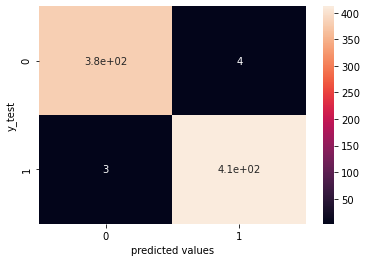

In [42]:
# Visual of confusion matrix of best model
fig = plt.subplot()
sns.heatmap(conmat, annot=True, ax=fig)
fig.set_ylabel('y_test')
fig.set_xlabel('predicted values')

In [43]:
import pickle

In [44]:
# Save model as model.pickle
with open('model.pickle', 'wb') as model_f:
    pickle.dump(best_rfc, model_f)

## Comparision to Base Model

Lets compare whether tuning the hyperparameters made a difference in model accuracy. We will train the base model from earlier.

In [ ]:
# The base model
#rfc = RandomForestClassifier(random_state=42)
pipeline

**Base model training**

In [46]:
# Training on base Random Forest model

# Fit to training set
pipeline.fit(X_train, y_train)

# Make prediction to test set
predicted_value = pipeline.predict(X_test)

# Get ROC score
rfc_accuracy_value = roc_auc_score(y_test, predicted_value)

**Training Accuracy**

In [47]:
# Random Forest Training ROC 100% lemmatized text
print("ROC: " + str(roc_auc_score(y_train, pipeline.predict(X_train))*100) + "%")

ROC: 100.0%


**Test Accuracy**

In [48]:
# Random Forest Test ROC 98.47% lemmatized text
print("ROC: " + str(rfc_accuracy_value*100) + "%")

ROC: 98.60898138006571%


Looks like after a total of less than 30 minutes of hyperparameter tuning, the accuracy has only increased by a small amount.

In [49]:
d = {
     'Model': ['Base Model', 'Tuned Model'],
     'Training Set Accuracy': [roc_auc_score(y_train, pipeline.predict(X_train)), roc_auc_score(y_train, best_rfc.predict(X_train))],
     'Test Set Accuracy': [rfc_accuracy_value, best_rfc_accuracy_value]
}

df_models_rfc = pd.DataFrame(d)

In [50]:
# Models table
df_models_rfc

,Model,Training Set Accuracy,Test Set Accuracy
0,Base Model,1.0,0.986090
1,Tuned Model,1.0,0.989986


**What was learnt from this exercise**
* How to use Pipeline to train model and CountVectorizer
* How to tuning hyperparameters with RandomSearchCV
* Narrow down choices of hyperparameter values with GridSearchCV
* Train models using cpu cores
* How to decrease training time
* Compare and evaluate best model to base model